TASK1 数据切分方式 - 三七分，其中测试集30%，训练集70%，随机种子设置为2018


TASK2 分别用IV值和随机森林等进行特征选择

TASK3 用逻辑回归、svm和决策树；随机森林和XGBoost进行模型构建，评分方式任意，如准确率等。

TASK4 Plot the curve of ROC

TASK5 使用网格搜索法对5个模型进行调优（调参时采用五折交叉验证的方式），并进行模型评估，记得展示代码的运行结果

TASK6 模型融合

In [7]:
############################################# 参考了libh的博客 在此感谢 ################################################
import pickle
import pandas as pd
from sklearn.model_selection import train_test_split


# def load_data(CSV_FILE_NAME):
CSV_FILE_NAME = 'data/data.csv'
DATA = pd.read_csv(CSV_FILE_NAME,encoding='gbk')
pd.set_option('display.max_columns',None) # 强制显示所有属性值
pd.set_option('display.max_rows',None)
DATA.sample(10)

,Unnamed: 0,custid,trade_no,bank_card_no,low_volume_percent,middle_volume_percent,take_amount_in_later_12_month_highest,trans_amount_increase_rate_lately,trans_activity_month,trans_activity_day,transd_mcc,trans_days_interval_filter,trans_days_interval,regional_mobility,student_feature,repayment_capability,is_high_user,number_of_trans_from_2011,first_transaction_time,historical_trans_amount,historical_trans_day,rank_trad_1_month,trans_amount_3_month,avg_consume_less_12_valid_month,abs,top_trans_count_last_1_month,avg_price_last_12_month,avg_price_top_last_12_valid_month,reg_preference_for_trad,trans_top_time_last_1_month,trans_top_time_last_6_month,consume_top_time_last_1_month,consume_top_time_last_6_month,cross_consume_count_last_1_month,trans_fail_top_count_enum_last_1_month,trans_fail_top_count_enum_last_6_month,trans_fail_top_count_enum_last_12_month,consume_mini_time_last_1_month,max_cumulative_consume_later_1_month,max_consume_count_later_6_month,railway_consume_count_last_12_month,pawns_auctions_trusts_consume_last_1_month,pawns_auctions_trusts_consume_last_6_month,jewelry_consume_count_last_6_month,status,source,first_transaction_day,trans_day_last_12_month,id_name,apply_score,apply_credibility,query_org_count,query_finance_count,query_cash_count,query_sum_count,latest_query_time,latest_one_month_apply,latest_three_month_apply,latest_six_month_apply,loans_score,loans_credibility_behavior,loans_count,loans_settle_count,loans_overdue_count,loans_org_count_behavior,consfin_org_count_behavior,loans_cash_count,latest_one_month_loan,latest_three_month_loan,latest_six_month_loan,history_suc_fee,history_fail_fee,latest_one_month_suc,latest_one_month_fail,loans_long_time,loans_latest_time,loans_credit_limit,loans_credibility_limit,loans_org_count_current,loans_product_count,loans_max_limit,loans_avg_limit,consfin_credit_limit,consfin_credibility,consfin_org_count_current,consfin_product_count,consfin_max_limit,consfin_avg_limit,latest_query_day,loans_latest_day
4459,11260,1492591,20180504180743017000000381804177,卡号1,0.00,0.97,1000,1.15,0.89,0.386,17.0,14.0,11.0,3.0,1.0,5200,0,24.0,20151208.0,202020,199.0,0.40,34100,5.0,1830,0.15,1380,0.50,一线城市,9.0,14.0,9.0,14.0,0.0,6.0,6.0,7.0,39.0,1280,3.0,0.0,0,18940,0.0,0,xs,895.0,82.0,范美娟,546.0,76.0,14.0,6.0,7.0,24.0,2018-04-14,3.0,12.0,19.0,513.0,73.0,75.0,65.0,3.0,18.0,5.0,13.0,2.0,8.0,32.0,79.0,36.0,2.0,2.0,355.0,2018-05-03,2000.0,70.0,13.0,13.0,3100.0,1630.0,15700.0,80.0,5.0,5.0,24000.0,11360.0,20.0,1.0
578,1421,1039411,20180507121526637000000023078410,卡号1,0.00,0.80,14000,0.92,0.83,0.236,14.0,21.0,13.0,2.0,1.0,10720,0,19.0,20160429.0,157790,111.0,0.25,35310,6.0,26790,0.20,1770,0.35,三线城市,6.0,13.0,8.0,13.0,0.0,0.0,2.0,3.0,57.0,5330,3.0,0.0,2600,24290,0.0,0,xs,752.0,83.0,杨星,637.0,79.0,9.0,6.0,2.0,13.0,2018-04-11,2.0,11.0,11.0,611.0,69.0,13.0,12.0,0.0,7.0,2.0,5.0,1.0,2.0,7.0,26.0,5.0,1.0,2.0,352.0,2018-04-21,3400.0,69.0,5.0,5.0,7500.0,3140.0,16300.0,69.0,2.0,2.0,25200.0,17400.0,26.0,16.0
4731,11936,1517438,20180507123928918000000388381394,卡号1,0.00,0.58,2000,2.63,0.73,0.525,19.0,30.0,12.0,4.0,1.0,7140,0,44.0,20130303.0,988560,302.0,0.85,43490,8.0,6180,0.20,2230,0.35,三线城市,15.0,30.0,15.0,30.0,0.0,4.0,7.0,9.0,1296678.0,110,12.0,0.0,190,110110,0.0,0,xs,1905.0,83.0,罗森方,508.0,79.0,17.0,5.0,11.0,23.0,2018-05-05,1.0,11.0,17.0,474.0,76.0,83.0,57.0,10.0,29.0,13.0,16.0,3.0,11.0,38.0,84.0,65.0,1.0,5.0,331.0,2018-04-26,1900.0,75.0,16.0,18.0,3100.0,1818.0,60200.0,78.0,13.0,15.0,124200.0,25361.0,2.0,11.0
299,761,1554205,20180507121715477000000023082582,卡号1,0.01,0.90,500,0.33,0.71,0.280,16.0,29.0,22.0,2.0,NaN,4740,0,20.0,20151109.0,151740,151.0,0.35,30550,5.0,2900,0.30,1950,0.40,一线城市,24.0,29.0,24.0,29.0,1.0,0.0,2.0,2.0,0.0,3520,6.0,0.0,590,17810,0.0,0,xs,924.0,84.0,江超,640.0,68.0,8.0,2.0,3.0,10.0,2018-04-14,4.0,6.0,9.0,621.0,77.0,27.0,27.0,0.0,12.0,3.0,9.0,3.0,4.0,10.0,34.0,2.0,3.0,0.0,360.0,2018-05-06,2200.0,76.0,9.0,9.0,3300.0,1811.0,15900.0,80.0,3.0,3.0,22800.0,8266.0,23.0,1.0
4202,10603,482315,2018050712

In [8]:
DATA.info() #This method prints information about a DataFrame 
#             including the index dtype and column dtypes, non-null values and memory usage.
#             可以查看缺失情况

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4754 entries, 0 to 4753
Data columns (total 90 columns):
Unnamed: 0                                    4754 non-null int64
custid                                        4754 non-null int64
trade_no                                      4754 non-null object
bank_card_no                                  4754 non-null object
low_volume_percent                            4752 non-null float64
middle_volume_percent                         4752 non-null float64
take_amount_in_later_12_month_highest         4754 non-null int64
trans_amount_increase_rate_lately             4751 non-null float64
trans_activity_month                          4752 non-null float64
trans_activity_day                            4752 non-null float64
transd_mcc                                    4752 non-null float64
trans_days_interval_filter                    4746 non-null float64
trans_days_interval                           4752 non-null float64
regional_mobility

In [10]:
# 选择出为object类型的数据
obj_vars = []
def find_object(df):
    print(' object类型的变量 ')
    for col in df.columns:
        if df[col].dtype == 'object':
#             print(col)
            obj_vars.append(col)
    return obj_vars

In [11]:
find_object(DATA)

 object类型的变量 


['trade_no',
 'bank_card_no',
 'reg_preference_for_trad',
 'source',
 'id_name',
 'latest_query_time',
 'loans_latest_time']

In [12]:
# 分别计算每个特征 缺失值情况，唯一值数量 唯一率
def desc(df):
    loss_num = [] # 缺失值的数量
    valid_num = [] # 非空的数量
    unique_num = [] # 唯一的数量
    unique_percent = [] # 唯一率
    for i,j in enumerate(df.columns):# enumerator 函数可以同时获得索引和值 i 索引 j 值
        loss_num.append(df[df[j].isnull()].shape[0]) # isnull() 表示的是空 返回的是True(空) False 
        valid_num.append(df[df[j].notnull()].shape[0])
        unique_num.append(len(df[j].unique()))
        unique_percent.append(len(df[df[j].notnull()][j].unique())/df[df[j].notnull()].shape[0])
    data_desc = pd.DataFrame({'loss_num':loss_num, 'valid_num':valid_num, 'unique_num':unique_num, 'unique_percent':unique_percent},
                             index=df.columns)
    return data_desc

data_count = desc(DATA)
data_count

,loss_num,valid_num,unique_num,unique_percent
Unnamed: 0,0,4754,4754,1.000000
custid,0,4754,4754,1.000000
trade_no,0,4754,4754,1.000000
bank_card_no,0,4754,1,0.000210
low_volume_percent,2,4752,41,0.008418
middle_volume_percent,2,4752,91,0.018939
take_amount_in_later_12_month_highest,0,4754,166,0.034918
trans_amount_increase_rate_lately,3,4751,783,0.164597
trans_activity_month,2,4752,85,0.017677
trans_activity_day,2,4752,513,0.107744


In [13]:
# DATA[DATA['trans_activity_month'].isnull()].shape[0]
DATA.dtypes.value_counts()

float64    70
int64      13
object      7
dtype: int64

In [14]:
# 分析字符类型和数值类型  这个是在选择列
num_features = DATA.select_dtypes(include = ['float64','int64']).copy()
obj_features = DATA.select_dtypes(include = ['object']).copy()
obj_features_desc = desc(obj_features)
obj_features_desc

,loss_num,valid_num,unique_num,unique_percent
trade_no,0,4754,4754,1.000000
bank_card_no,0,4754,1,0.000210
reg_preference_for_trad,2,4752,6,0.001052
source,0,4754,1,0.000210
id_name,276,4478,4310,0.962260
latest_query_time,304,4450,208,0.046517
loans_latest_time,297,4457,233,0.052053


In [15]:
# import datetime

# # latest_query_time loans_lastest_time 两个字段可以构成时间差 对字符类型变量做转换，转换成datatime类型字段
# # df.drop() 是删除行或者列
# # 转换前先去掉null数据
# DATA.drop(index = list(DATA[DATA['latest_query_time'].isnull()].index),axis=0,inplace=True)
# DATA.drop(index = list(DATA[DATA['loans_latest_time'].isnull()].index),axis=0,inplace=True)
# # inplace=True：不创建新的对象，直接对原始对象进行修改；
# # # inplace=False：对数据进行修改，创建并返回新的对象承载其修改结果。
# latest_query_time_days = []
# loans_latest_time_days = [] 
# for i in obj_features.index:
#     a=datetime.datetime.strptime(DATA['trade_no'][i][0:4]+'-'+DATA['trade_no'][i][4:6]+'-'+DATA['trade_no'][i][6:8],'%Y-%m-%d')
    
#     #-datetime.datetime.strptime(DATA['latest_query_time'][i],'%Y-%m-%d')
# # #     a = datetime.datetime.strptime(DATA['trade_no'][i][0:4]+'-'+DATA['trade_no'][i][4:6]+'-'+DATA['trade_no'][i][6:8],'%Y-%m-%d')-datetime.datetime.strptime(DATA['latest_query_time'][i],'%Y-%m-%d')
# # #     b=datetime.datetime.strptime(DATA['trade_no'][i][0:4]+'-'+DATA['trade_no'][i][4:6]+'-'+DATA['trade_no'][i][6:8],'%Y-%m-%d')-datetime.datetime.strptime(DATA['loans_latest_time'][i],'%Y-%m-%d')
# # #     b = datetime.datetime.strptime(DATA['trade_no'][i][0:4]+'-'+DATA['trade_no'][i][4:6]+'-'+DATA['trade_no'][i][6:8],'%Y-%m-%d')-datetime.datetime.strptime(DATA['loans_latest_time'][i],'%Y-%m-%d')
# #     latest_query_time_days.append(a.days)
# #     loans_latest_time_days.append(b.days)

In [16]:
# 删除部分特征
DATA.drop(columns = ['latest_query_time','loans_latest_time'],axis = 1,inplace = True)
DATA.drop(columns = ['trade_no'],axis=1,inplace=True)
DATA.drop(columns = ['id_name','bank_card_no','source'],axis=1,inplace=True)

DATA['reg_preference_for_trad'].replace({'一线城市':1,'二线城市':2,'三线城市':3,'境外':4,'其他城市':5},inplace = True)
# 处理num_features
num_features_desc = desc(num_features)

In [17]:
DATA.drop(columns = ['Unnamed: 0','custid'],axis=1,inplace=True)
DATA.drop(columns = ['student_feature'],axis=1,inplace=True)
num_features.drop(columns=['student_feature'],axis=1,inplace=True)
num_features_desc_new = desc(num_features)
# num_features_desc_new

In [18]:
# 分训练集和测试集 
from sklearn.model_selection import train_test_split
df_1,Y = DATA.drop(columns=['status'],axis=1),DATA['status']

In [19]:
# # 使用众数来填充
# for i in num_features_desc_new[num_features_desc_new['loss_num']!=0].index: # 通过desc 获得了属性
#     if i not in(DATA.columns):
#         continue
#     else:
#         value = DATA[i].value_counts().index[0]
#         DATA[i].fillna(value,inplace=True)

# 缺失值采用均值填充
from sklearn.preprocessing import Imputer # Imputer 是缺失值处理器
imputer = Imputer(strategy='median')
df_2 = imputer.fit_transform(df_1) 
df_2 = pd.DataFrame(df_2,columns=df_1.columns)

D:\Anaconda\envs\tensorflow-gpu\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [20]:
# 数据标准化 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_3 = scaler.fit_transform(df_2) # 生成结果是array类型，需要转化为df类型
df_3 = pd.DataFrame(df_3,columns=df_2.columns)
df_3.head()

,low_volume_percent,middle_volume_percent,take_amount_in_later_12_month_highest,trans_amount_increase_rate_lately,trans_activity_month,trans_activity_day,transd_mcc,trans_days_interval_filter,trans_days_interval,regional_mobility,repayment_capability,is_high_user,number_of_trans_from_2011,first_transaction_time,historical_trans_amount,historical_trans_day,rank_trad_1_month,trans_amount_3_month,avg_consume_less_12_valid_month,abs,top_trans_count_last_1_month,avg_price_last_12_month,avg_price_top_last_12_valid_month,reg_preference_for_trad,trans_top_time_last_1_month,trans_top_time_last_6_month,consume_top_time_last_1_month,consume_top_time_last_6_month,cross_consume_count_last_1_month,trans_fail_top_count_enum_last_1_month,trans_fail_top_count_enum_last_6_month,trans_fail_top_count_enum_last_12_month,consume_mini_time_last_1_month,max_cumulative_consume_later_1_month,max_consume_count_later_6_month,railway_consume_count_last_12_month,pawns_auctions_trusts_consume_last_1_month,pawns_auctions_trusts_consume_last_6_month,jewelry_consume_count_last_6_month,first_transaction_day,trans_day_last_12_month,apply_score,apply_credibility,query_org_count,query_finance_count,query_cash_count,query_sum_count,latest_one_month_apply,latest_three_month_apply,latest_six_month_apply,loans_score,loans_credibility_behavior,loans_count,loans_settle_count,loans_overdue_count,loans_org_count_behavior,consfin_org_count_behavior,loans_cash_count,latest_one_month_loan,latest_three_month_loan,latest_six_month_loan,history_suc_fee,history_fail_fee,latest_one_month_suc,latest_one_month_fail,loans_long_time,loans_credit_limit,loans_credibility_limit,loans_org_count_current,loans_product_count,loans_max_limit,loans_avg_limit,consfin_credit_limit,consfin_credibility,consfin_org_count_current,consfin_product_count,consfin_max_limit,consfin_avg_limit,latest_query_day,loans_latest_day
0,-0.284251,0.612374,-0.494499,-0.019099,-1.292452,-0.308087,-0.112363,-0.088968,0.258090,0.360860,0.022753,-0.10618,0.692904,-1.369779,-0.254902,-0.251892,-0.291688,-0.048501,0.307283,-0.200866,-0.586819,-0.283482,0.359037,-0.607021,-0.589808,-0.090286,-0.559014,-0.125456,0.185119,-0.343141,-0.567477,-0.679726,-0.413810,-0.066310,-0.009482,-0.06427,0.098065,-0.032583,-0.070986,1.306978,-0.210048,0.162824,0.744130,-0.573951,-1.071835,0.898350,-0.618796,-0.511258,-0.495333,-0.468581,0.181537,-1.114585,0.056879,0.152786,-0.074027,-0.387104,-1.277708,0.183572,0.064395,-0.528249,-0.070807,-0.195812,-0.419795,-0.077578,-0.325010,0.143002,0.160311,-0.011200,0.183572,0.243381,-0.330249,-0.233181,-1.104758,-0.087098,-1.277708,-0.973381,-1.068511,-1.226123,-0.313460,-0.692110
1,-0.043372,0.267106,0.015242,-0.018551,0.993418,0.544138,0.334643,0.043178,-0.470508,1.484325,-0.033172,-0.10618,-0.003284,0.629181,0.225221,0.480625,-0.481307,-0.278903,-1.131244,-0.088664,-0.872126,-0.035373,-0.144462,-0.607021,1.104079,0.759046,1.092095,0.713390,-0.260705,-0.867841,-0.342699,-0.469156,-0.412939,-0.072784,0.518751,-0.06427,0.075393,-0.116306,-0.070986,-0.479054,-0.262502,1.563991,-0.743608,-0.720664,-0.529789,-0.687817,-0.801593,-0.511258,-0.359945,-0.468581,1.575899,0.272156,0.056879,0.247907,-0.725735,0.583222,0.108626,0.759359,0.746206,-0.229889,-0.546658,0.212011,-0.542939,0.447042,-0.060665,0.487904,-0.131074,0.178959,0.759359,0.601927,0.089632,-0.109253,0.840507,0.267713,0.108626,0.238311,0.490237,0.256592,-0.532163,-0.999858
2,0.438384,0.405213,-0.494499,-0.018955,0.993418,-1.477693,-1.006374,1.717020,0.015224,-1.886068,-0.172220,-0.10618,-1.395661,1.319374,-0.684068,-1.456030,1.983740,-0.326870,-1.131244,-0.314920,0.839719,-0.871108,1.366034,-0.607021,-1.342647,3.693101,-1.292840,3.611224,-0.260705,0.706259,0.331635,0.162557,-0.413823,-0.267007,-0.537715,-0.06427,-0.199698,-0.672568,-0.070986,-1.300367,0.314493,1.584008,0.000261,-0.133813,-0.258766,0.501808,-0.070404,0.172112,-0.495333,0.198742,1.542300,3.507884,-1.326158,-1.369149,-0.725735,-1.357430,-1.277708,-1.159931,0.746206,-0.229889,-0

In [21]:
X_train,X_test,y_train,y_test = train_test_split(df_3,Y,train_size=0.7,test_size=0.3,random_state=2018)

In [22]:
print(X_train.shape)
print(y_train.shape)

(3327, 80)
(3327,)


TASK2

In [23]:
########################################## TAST2 参考自 libh 的CSDN博客 在此感谢 ################################################
import math
import numpy as np
from scipy import stats # 统计 包括统计工具和随机过程的概率过程
from sklearn.utils.multiclass import type_of_target
from sklearn.metrics import accuracy_score, roc_auc_score

In [24]:
# 性能评估
def model_metrics(clf, X_train, X_test, y_train, y_test):
    # 预测
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)
    
    y_train_proba = clf.predict_proba(X_train)[:,1]
    y_test_proba = clf.predict_proba(X_test)[:,1]
    
    # 准确率
    print('[准确率]', end = ' ')
    print('训练集：', '%.4f'%accuracy_score(y_train, y_train_pred), end = ' ')
    print('测试集：', '%.4f'%accuracy_score(y_test, y_test_pred))
    
    # auc取值：用roc_auc_score或auc
    print('[auc值]', end = ' ')
    print('训练集：', '%.4f'%roc_auc_score(y_train, y_train_proba), end = ' ')
    print('测试集：', '%.4f'%roc_auc_score(y_test, y_test_proba))

In [25]:
xx = X_train['trans_activity_day'].values
res1 = np.zeros(xx.shape)
point1 = stats.scoreatpercentile(xx,0*20)
point2 = stats.scoreatpercentile(xx,(0+1)*20)
xx1 = xx[np.where((xx>=point1)&(xx<=point2))]
mask1 = np.in1d(xx,xx1)
res1[mask1] = 1

In [26]:
def descrete(x):
    # 使用5等分化特征
    res = np.zeros(x.shape)
    for i in range(5):
        point1 = stats.scoreatpercentile(x,i*20) # 这个是从小到大这样排列的
        point2 = stats.scoreatpercentile(x,(i+1)*20)
        x1 = x[np.where((x>=point1)&(x<=point2))]
        mask = np.in1d(x,x1) # 在x中寻找和x1相同的值 返回逻辑值向量
        res[mask] = i+1 # 这个res 表示的是该参数的每个样本所属的类别
    return res

def woe_single_x(x,y,feature,event=1):
    # event代表预测正例的标签
    event_total = sum(y==event)
    non_event_total = y.shape[-1] - event_total
    
    iv = 0
    woe_dict = {}
    for x1 in set(x): # set 是集合 因此没有重复的信息 所以就是处理每一个组
        y1 = y.reindex(np.where(x == x1)[0]) # reindex 后会重新排序
        event_count = sum(y1 == event)
        non_event_count = y1.shape[-1]-event_count
        rate_event = event_count / event_total
        rate_non_event = non_event_count/non_event_total
        
        if rate_event == 0:
            rate_event = 0.0001
        elif rate_non_event ==0:
            rate_non_event =0.0001
        woei = math.log(rate_event/rate_non_event)
        woe_dict[x1] = woei
        iv += (rate_event-rate_non_event)*woei
    return woe_dict,iv
    

In [27]:
def woe(X,y,event = 1): # 相当于计算各个特征对应的iv值 information value
    res_woe = []
    iv_dict = {}
    for feature in X.columns:
        x = X[feature].values
        # 对连续特征离散化
        if type_of_target(x) == 'continuout':
            x = discrete(x)
        # 计算特征的woe和iv
        woe_dict,iv = woe_single_x(x,y,feature,event) # 这里的x 已经不是数据了 是属于哪一个分组的信息
        iv_dict[feature] = iv
        res_woe.append(woe_dict)
    return iv_dict

In [28]:
import warnings
warnings.filterwarnings('ignore')

iv_dict = woe(X_train,y_train)
iv = sorted(iv_dict.items(),key = lambda x:x[1],reverse = True) # 这个排序 没看懂

In [29]:
iv

[('historical_trans_amount', 2.660964613451281),
 ('trans_amount_3_month', 2.5546436077538432),
 ('repayment_capability', 2.327229251967252),
 ('pawns_auctions_trusts_consume_last_6_month', 2.2207773896414884),
 ('first_transaction_day', 2.165187321071266),
 ('first_transaction_time', 2.165187321071263),
 ('abs', 1.9669858256437216),
 ('consfin_avg_limit', 1.6927490494187978),
 ('loans_avg_limit', 1.4616638505356834),
 ('max_cumulative_consume_later_1_month', 1.459866046556418),
 ('consume_mini_time_last_1_month', 1.3790560008629493),
 ('trans_amount_increase_rate_lately', 1.195109127153687),
 ('trans_activity_day', 1.1536695878818595),
 ('historical_trans_day', 1.117648762849401),
 ('consfin_credit_limit', 0.8696092766406972),
 ('pawns_auctions_trusts_consume_last_1_month', 0.8530625616084092),
 ('avg_price_last_12_month', 0.7281431950917352),
 ('loans_score', 0.6611588082229922),
 ('loans_latest_day', 0.6295469820926425),
 ('apply_score', 0.6273343581887719),
 ('history_suc_fee', 0.5

In [30]:
# 随机森林挑选特征  决策树 随机森林没系统学过 随机森林不需要做oh编码，不需要做归一化
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import GridSearchCV # 这个是python 的超参数自动搜索模块
from sklearn.ensemble import RandomForestClassifier # ensemble 集成学习

In [31]:
# # 观察默认参数的性能
# rf0 = RandomForestClassifier(oob_score=True)
# rf0.fit(train_x,train_y)
# print('袋外分数：',rf0.oob_score_)
# model_metrics(rf0,train_x,test_x,train_y,test_y)

# 观察默认参数的性能
rf0 = RandomForestClassifier(oob_score=True, random_state=2018)
rf0.fit(X_train, y_train)
print('袋外分数：', rf0.oob_score_)
model_metrics(rf0, X_train, X_test, y_train, y_test)

袋外分数： 0.7382025849113315
[准确率] 训练集： 0.9835 测试集： 0.7701
[auc值] 训练集： 0.9992 测试集： 0.7225


In [32]:
# 网格法调参
param_test = {'n_estimators':range(20,200,20)}# 20 40 60 80 100

gsearch = GridSearchCV(estimator = RandomForestClassifier(n_estimators = 120,max_depth = 9,min_samples_split = 50,
                                                           min_samples_leaf=20,max_features = 9,random_state=2018),
                                param_grid = param_test,scoring = 'roc_auc',cv=5)
gsearch.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=9, max_features=9, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=20, min_samples_split=50,
            min_weight_fraction_leaf=0.0, n_estimators=120, n_jobs=None,
            oob_score=False, random_state=2018, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': range(20, 200, 20)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [33]:
gsearch.best_params_,gsearch.best_score_

({'n_estimators': 40}, 0.7911502040915114)

In [34]:
rf = RandomForestClassifier(n_estimators=120, max_depth=9, min_samples_split=50,
                            min_samples_leaf=20, max_features = 9,oob_score=True, random_state=2018)
rf.fit(X_train, y_train)
print('oob：', rf.oob_score_)
model_metrics(rf, X_train, X_test, y_train, y_test)

oob： 0.7908025247971145
[准确率] 训练集： 0.8206 测试集： 0.7835
[auc值] 训练集： 0.9020 测试集： 0.7731


平均不纯度减小 mean decrease impurity

In [35]:
rf.fit(X_train, y_train)
feature_importance1 = sorted(zip(map(lambda x: '%.4f'%x, rf.feature_importances_), list(X_train.columns)), reverse=True)
#zip() 函数用于将可迭代的对象作为参数，将对象中对应的元素打包成一个个元组，然后返回由这些元组组成的列表。

In [36]:
feature_importance1[:10]

[('0.1364', 'trans_fail_top_count_enum_last_1_month'),
 ('0.0839', 'history_fail_fee'),
 ('0.0830', 'loans_score'),
 ('0.0605', 'loans_overdue_count'),
 ('0.0460', 'latest_one_month_fail'),
 ('0.0441', 'apply_score'),
 ('0.0295', 'trans_fail_top_count_enum_last_12_month'),
 ('0.0293', 'trans_fail_top_count_enum_last_6_month'),
 ('0.0219', 'trans_day_last_12_month'),
 ('0.0203', 'latest_one_month_suc')]

平均精确度减少 Mean ducrease accuracy

In [37]:
import numpy as np
from collections import defaultdict
from sklearn.model_selection import cross_val_score, ShuffleSplit

scores = defaultdict(list)
rs = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
for train_idx, test_idx in rs.split(X_train):
    x_train, x_test = X_train.values[train_idx], X_train.values[test_idx]
    Y_train, Y_test = y_train.values[train_idx], y_train.values[test_idx]
    r = rf.fit(x_train, Y_train)
    acc = accuracy_score(Y_test, rf.predict(x_test))
    for i in range(x_train.shape[1]):
        X_t = x_test.copy()
        np.random.shuffle(X_t[:, i])
        shuff_acc = accuracy_score(Y_test, rf.predict(X_t))
        scores[X_train.columns[i]].append((acc - shuff_acc) / acc)
        
feature_importance2=sorted([('%.4f'%np.mean(score), feat) for feat, score in scores.items()], reverse=True)

In [38]:
feature_importance2[:10]

[('0.0168', 'trans_fail_top_count_enum_last_1_month'),
 ('0.0109', 'history_fail_fee'),
 ('0.0081', 'loans_score'),
 ('0.0061', 'loans_overdue_count'),
 ('0.0028', 'trans_fail_top_count_enum_last_12_month'),
 ('0.0028', 'latest_one_month_suc'),
 ('0.0028', 'latest_one_month_fail'),
 ('0.0028', 'apply_score'),
 ('0.0025', 'trans_fail_top_count_enum_last_6_month'),
 ('0.0015', 'consfin_org_count_current')]

综合挑选特征

In [39]:
feature_importance1[50],feature_importance2[40]

(('0.0052', 'apply_credibility'),
 ('-0.0023', 'max_cumulative_consume_later_1_month'))

In [40]:
useless = []
for feature in X_train.columns:
    if feature in [t[1] for t in feature_importance1[50:]] and feature in [t[1] for t in feature_importance2[40:]]:
        useless.append(feature)
        print(feature,iv_dict[feature])

low_volume_percent 0.2711148958454505
middle_volume_percent 0.38361434098849495
take_amount_in_later_12_month_highest 0.44072072652199673
transd_mcc 0.29116590649782825
regional_mobility 0.22209882955283974
avg_price_top_last_12_valid_month 0.24626833262939193
apply_credibility 0.2953860515586046
latest_six_month_apply 0.3504779072839909
loans_credibility_behavior 0.2569412073649464
consfin_org_count_behavior 0.25911814003029604
loans_cash_count 0.2558709619714511
loans_credit_limit 0.29628915057605293
loans_org_count_current 0.2558709619714511
consfin_product_count 0.24767574576422638


In [41]:
len(useless)

14

In [42]:
X_train.drop(useless, axis = 1, inplace = True)
X_test.drop(useless, axis = 1, inplace = True)

Task3 用逻辑回归、svm和决策树；随机森林和XGBoost进行模型构建，评分方式任意，如准确率等。（不需要考虑模型调参）时间：2天

In [43]:
########################################## TAST3 参考自 libh 的CSDN博客 在此感谢 ################################################
########################################## TASK5 网格调参内容 ##################################################################
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from xgboost.sklearn import XGBClassifier
# from lightgbm.sklearn import LGBMClassifier
# from sklearn.model_selection import GridSearchCV # 这个是python 的超参数自动搜索模块

LogisticRegression

In [44]:
lr = LogisticRegression(C= 0.1,penalty = 'l1')
param = {'C':[1e-3,0.01,0.1,1,10,100,1e3],'penalty':['l1','l2']}

gsearch = GridSearchCV(lr, param_grid = param,scoring ='roc_auc', cv=5)
gsearch.fit(X_train, y_train) # 先定义出参数 然后用gsearch去fit 训练 寻找

print('最佳参数：',gsearch.best_params_)
print('训练集的最佳分数：', gsearch.best_score_)
print('测试集的最佳分数：', gsearch.score(X_test, y_test))

# lr.fit(X_train, y_train) # work


最佳参数： {'C': 0.1, 'penalty': 'l1'}
训练集的最佳分数： 0.7935794839713376
测试集的最佳分数： 0.7810188517834601


In [45]:
lr = LogisticRegression(C=0.1,penalty = 'l1')
lr.fit(X_train,y_train)
model_metrics(lr,X_train,X_test,y_train,y_test)

[准确率] 训练集： 0.8016 测试集： 0.7856
[auc值] 训练集： 0.8114 测试集： 0.7810


SVM

In [46]:
# svm_linear = svm.SVC(C = 0.01,kernel = 'linear',probability = True).fit(X_train, y_train)
# svm_poly = svm.SVC(C = 0.01,kernel = 'poly',probability = True).fit(X_train, y_train)
# svm_rbf = svm.SVC(gamma = 0.01,C = 0.01,probability = True).fit(X_train, y_train)

In [47]:
svm_linear = svm.SVC(kernel = 'linear',probability = True)
param = {'C':[0.01,0.1,1]}
gsearch = GridSearchCV(svm_linear,param_grid=param,scoring = 'roc_auc',cv=5)
gsearch.fit(X_train,y_train)

print('最佳参数：',gsearch.best_params_)
print('训练集的最佳分数：', gsearch.best_score_)
print('测试集的最佳分数：', gsearch.score(X_test, y_test))

最佳参数： {'C': 0.01}
训练集的最佳分数： 0.797019887671426
测试集的最佳分数： 0.784002587295129


In [48]:
svm_linear = svm.SVC(C = 0.01, kernel = 'linear', probability=True)
svm_linear.fit(X_train, y_train)
model_metrics(svm_linear, X_train, X_test, y_train, y_test)

[准确率] 训练集： 0.7959 测试集： 0.7800
[auc值] 训练集： 0.8126 测试集： 0.7840


In [49]:
svm_poly = svm.SVC(kernel = 'poly',probability = True)
param = {'C':[0.01,0.1,1]}
gsearch = GridSearchCV(svm_poly, param_grid = param,scoring ='roc_auc', cv=5)
gsearch.fit(X_train, y_train) 

print('最佳参数：',gsearch.best_params_)
print('训练集的最佳分数：', gsearch.best_score_)
print('测试集的最佳分数：', gsearch.score(X_test, y_test))

最佳参数： {'C': 0.01}
训练集的最佳分数： 0.7508016112653715
测试集的最佳分数： 0.7417634294179629


In [50]:
svm_poly =  svm.SVC(C = 0.01, kernel = 'poly', probability=True)
svm_poly.fit(X_train, y_train)
model_metrics(svm_poly, X_train, X_test, y_train, y_test)

[准确率] 训练集： 0.7580 测试集： 0.7519
[auc值] 训练集： 0.8437 测试集： 0.7418


In [51]:
svm_rbf = svm.SVC(probability = True)
param = {'gamma':[0.01,0.1,1],
        'C':[0.01,0.1,1]}
gsearch = GridSearchCV(svm_rbf,param_grid = param,scoring ='roc_auc', cv=5)
gsearch.fit(X_train, y_train)
print('最佳参数：',gsearch.best_params_)
print('训练集的最佳分数：', gsearch.best_score_)
print('测试集的最佳分数：', gsearch.score(X_test, y_test))

最佳参数： {'C': 0.1, 'gamma': 0.01}
训练集的最佳分数： 0.7935060250024045
测试集的最佳分数： 0.7761494162936997


In [52]:
svm_rbf =  svm.SVC(gamma = 0.01, C =0.01 , probability=True)
svm_rbf.fit(X_train, y_train)
model_metrics(svm_rbf, X_train, X_test, y_train, y_test)#################

[准确率] 训练集： 0.7493 测试集： 0.7484
[auc值] 训练集： 0.8300 测试集： 0.7761


 DecisionTree

In [53]:
# 首先对决策树最大深度max_depth 内部节点再划分所需最小样本数min_samples_split进行网格搜索。
param = {'max_depth':range(3,14,2), 'min_samples_split':range(100,801,200)}
gsearch = GridSearchCV(DecisionTreeClassifier(max_depth=8,min_samples_split=300,min_samples_leaf=20, max_features='sqrt',random_state =2018),
                       param_grid = param,scoring ='roc_auc', cv=5)

gsearch.fit(X_train, y_train)
# gsearch.grid_scores_, 
gsearch.best_params_, gsearch.best_score_

# dt = DecisionTreeClassifier(max_depth=5,min_samples_split=50,min_samples_leaf=60,max_features=9,random_state=2018)
# dt.fit(X_train, y_train)


({'max_depth': 7, 'min_samples_split': 300}, 0.7029601310759873)

In [54]:
#对内部节点再划分所需最小样本数min_samples_split和叶子节点最少样本数min_samples_leaf一起调参。
param = {'min_samples_split':range(50,1000,100), 'min_samples_leaf':range(60,101,10)}
gsearch = GridSearchCV(DecisionTreeClassifier(max_depth=9,min_samples_split=100,min_samples_leaf=20, max_features='sqrt', random_state =2333),
                       param_grid = param,scoring ='roc_auc', cv=5)

gsearch.fit(X_train, y_train)
# gsearch.grid_scores_, 
gsearch.best_params_, gsearch.best_score_

({'min_samples_leaf': 60, 'min_samples_split': 50}, 0.7228728867150015)

In [55]:
# 再对最大特征数max_features进行网格搜索
param = {'max_features':range(7,20,2)}
gsearch = GridSearchCV(DecisionTreeClassifier(max_depth=9,min_samples_split=50,min_samples_leaf=90, max_features='sqrt', random_state =2333),
                       param_grid = param,scoring ='roc_auc', cv=5)

gsearch.fit(X_train, y_train)
# gsearch.grid_scores_, 
gsearch.best_params_, gsearch.best_score_

({'max_features': 17}, 0.7410402594341049)

In [56]:
dt = DecisionTreeClassifier(max_depth=9,min_samples_split=50,min_samples_leaf=90,max_features=15, random_state =2018)
dt.fit(X_train, y_train)
model_metrics(dt, X_train, X_test, y_train, y_test)

[准确率] 训练集： 0.7812 测试集： 0.7631
[auc值] 训练集： 0.7807 测试集： 0.7091


XGBoost模型

In [57]:
import warnings
warnings.filterwarnings("ignore")

xgb0 = XGBClassifier()
xgb0.fit(X_train, y_train)

model_metrics(xgb0, X_train, X_test, y_train, y_test)

[准确率] 训练集： 0.8503 测试集： 0.7800
[auc值] 训练集： 0.9105 测试集： 0.7677


In [58]:
#  首先从步长(learning rate)和迭代次数(n_estimators)入手。
param_test = {'n_estimators':range(20,200,20)}
gsearch = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=140, max_depth=5, 
                                                  min_child_weight=1, gamma=0, subsample=0.8, 
                                                  colsample_bytree=0.8, objective= 'binary:logistic', 
                                                  nthread=4,scale_pos_weight=1, seed=27), 
                        param_grid = param_test, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch.fit(X_train, y_train)
# gsearch.grid_scores_, 
gsearch.best_params_, gsearch.best_score_

({'n_estimators': 40}, 0.7966175009423511)

In [59]:
#2) max_depth 和 min_child_weight 参数调优
param_test = {'max_depth':range(3,10,2), 'min_child_weight':range(1,12,2)}

gsearch = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=40, max_depth=5, 
                                                  min_child_weight=1, gamma=0, subsample=0.8, 
                                                  colsample_bytree=0.8, objective= 'binary:logistic', 
                                                  nthread=4,scale_pos_weight=1, seed=27), 
                        param_grid = param_test, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch.fit(X_train, y_train)
# gsearch.grid_scores_, 
gsearch.best_params_, gsearch.best_score_

({'max_depth': 5, 'min_child_weight': 3}, 0.8035672472200703)

In [60]:
param_test = {'max_depth':[3,4,2], 'min_child_weight':[5,7,9]}

gsearch = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=40, max_depth=3, 
                                                  min_child_weight=1, gamma=0, subsample=0.8, 
                                                  colsample_bytree=0.8, objective= 'binary:logistic', 
                                                  nthread=4,scale_pos_weight=1, seed=27), 
                        param_grid = param_test, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch.fit(X_train, y_train)
# gsearch.grid_scores_, 
gsearch.best_params_, gsearch.best_score_

({'max_depth': 4, 'min_child_weight': 7}, 0.8023817852565648)

In [61]:
param_test = {'gamma':[i/10 for i in range(1,6)]}

gsearch = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=40, max_depth=3, 
                                                  min_child_weight=9, gamma=0, subsample=0.8, 
                                                  colsample_bytree=0.8, objective= 'binary:logistic', 
                                                  nthread=4,scale_pos_weight=1, seed=27), 
                        param_grid = param_test, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch.fit(X_train, y_train)
# gsearch.grid_scores_, 
gsearch.best_params_, gsearch.best_score_

({'gamma': 0.5}, 0.8005345192523171)

In [62]:
# 调整subsample 和 colsample_bytree 参数
param_test = {'subsample':[i/10 for i in range(5,10)], 'colsample_bytree':[i/10 for i in range(5,10)]}

gsearch = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=40, max_depth=3, 
                                                  min_child_weight=9, gamma=0.4, subsample=0.8, 
                                                  colsample_bytree=0.8, objective= 'binary:logistic', 
                                                  nthread=4,scale_pos_weight=1, seed=27), 
                        param_grid = param_test, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch.fit(X_train, y_train)
# gsearch.grid_scores_, 
gsearch.best_params_, gsearch.best_score_

({'colsample_bytree': 0.8, 'subsample': 0.9}, 0.8019398401007743)

In [63]:
param_test = { 'subsample':[i/100 for i in range(85,101,5)], 'colsample_bytree':[i/100 for i in range(85,101,5)]}

gsearch = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=40, max_depth=3, 
                                                  min_child_weight=9, gamma=0.4, subsample=0.8, 
                                                  colsample_bytree=0.8, objective= 'binary:logistic', 
                                                  nthread=4,scale_pos_weight=1, seed=27), 
                        param_grid = param_test, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch.fit(X_train, y_train)
# gsearch.grid_scores_, 
gsearch.best_params_, gsearch.best_score_

({'colsample_bytree': 0.95, 'subsample': 0.95}, 0.8046538429149799)

In [64]:
# 正则化参数
#  'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
param_test = {'reg_alpha':[1e-5, 1e-2, 0.1, 0, 1, 100]}
gsearch = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=40, max_depth=3, 
                                                  min_child_weight=9, gamma=0.4, subsample=0.8, 
                                                  colsample_bytree=0.85, objective= 'binary:logistic', 
                                                  nthread=4,scale_pos_weight=1, seed=27), 
                        param_grid = param_test, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch.fit(X_train, y_train)
# gsearch.grid_scores_, 
gsearch.best_params_, gsearch.best_score_

({'reg_alpha': 0.01}, 0.8006933865883236)

In [65]:
xgb = XGBClassifier(learning_rate =0.01, n_estimators=40, max_depth=3, min_child_weight=9, 
                    gamma=0.4, subsample=0.8, colsample_bytree=0.85, reg_alpha=1, 
                    objective= 'binary:logistic', nthread=4,scale_pos_weight=1, seed=27)
xgb.fit(X_train, y_train)
model_metrics(xgb, X_train, X_test, y_train, y_test)

[准确率] 训练集： 0.8004 测试集： 0.7821
[auc值] 训练集： 0.8071 测试集： 0.7518


In [66]:
# xgb = XGBClassifier(learning_rate = 0.1,n_eatimators=80,max_depth=3,min_child_weight=5,
#                    gamma=0.2,subsample=0.8,colsample_bytree=0.8,reg_alpha=1e-5,
#                    objective = 'binary:logistic',nthread=4,scale_pos_weight=1,seed=27)
# xgb.fit(X_train, y_train)

模型评估

In [67]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from sklearn.metrics import  roc_auc_score,roc_curve,auc
import matplotlib.pyplot as plt
%matplotlib inline

In [68]:
def model_metrics(clf,X_train,X_test,y_train,y_test):
    # predict
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)
    
    y_train_proba = clf.predict_proba(X_train)[:,1]
    y_test_proba = clf.predict_proba(X_test)[:,1]
    # 准确率
    print('[准确率]', end = ' ')
    print('训练集：', '%.4f'%accuracy_score(y_train, y_train_pred), end = ' ')
    print('测试集：', '%.4f'%accuracy_score(y_test, y_test_pred))
    
    # 精准率
    print('[精准率]', end = ' ')
    print('训练集：', '%.4f'%precision_score(y_train, y_train_pred), end = ' ')
    print('测试集：', '%.4f'%precision_score(y_test, y_test_pred))

    # 召回率
    print('[召回率]', end = ' ')
    print('训练集：', '%.4f'%recall_score(y_train, y_train_pred), end = ' ')
    print('测试集：', '%.4f'%recall_score(y_test, y_test_pred))
    
    # f1-score
    print('[f1-score]', end = ' ')
    print('训练集：', '%.4f'%f1_score(y_train, y_train_pred), end = ' ')
    print('测试集：', '%.4f'%f1_score(y_test, y_test_pred))
    
    # AUC（Area Under Curve）被定义为ROC曲线下与坐标轴围成的面积
    # auc取值：用roc_auc_score或auc
    print('[auc值]', end = ' ')
    print('训练集：', '%.4f'%roc_auc_score(y_train, y_train_proba), end = ' ')
    print('测试集：', '%.4f'%roc_auc_score(y_test, y_test_proba))
    
    # roc曲线
    fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_proba, pos_label = 1)
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_proba, pos_label = 1)
    
    label = ["Train - AUC:{:.4f}".format(auc(fpr_train, tpr_train)), 
             "Test - AUC:{:.4f}".format(auc(fpr_test, tpr_test))]
    plt.plot(fpr_train,tpr_train)
    plt.plot(fpr_test,tpr_test)
    plt.plot([0, 1], [0, 1], 'd--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(label, loc = 4)
    plt.title("ROC curve")

TASK 4

[准确率] 训练集： 0.8016 测试集： 0.7856
[精准率] 训练集： 0.7143 测试集： 0.6688
[召回率] 训练集： 0.3477 测试集： 0.2925
[f1-score] 训练集： 0.4677 测试集： 0.4070
[auc值] 训练集： 0.8114 测试集： 0.7810


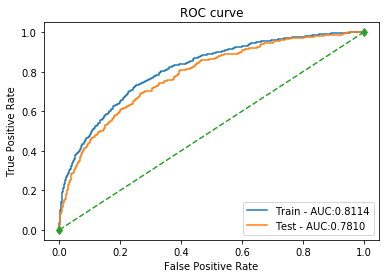

In [69]:
# 逻辑回归
model_metrics(lr, X_train, X_test, y_train, y_test)

[准确率] 训练集： 0.7959 测试集： 0.7800
[精准率] 训练集： 0.7903 测试集： 0.7143
[召回率] 训练集： 0.2530 测试集： 0.2089
[f1-score] 训练集： 0.3833 测试集： 0.3233
[auc值] 训练集： 0.8126 测试集： 0.7840


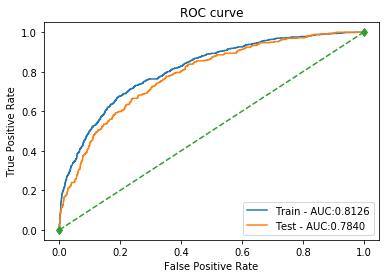

In [70]:
# 线性SVM
model_metrics(svm_linear, X_train, X_test, y_train, y_test)

[准确率] 训练集： 0.7580 测试集： 0.7519
[精准率] 训练集： 1.0000 测试集： 0.6923
[召回率] 训练集： 0.0348 测试集： 0.0251
[f1-score] 训练集： 0.0672 测试集： 0.0484
[auc值] 训练集： 0.8437 测试集： 0.7418


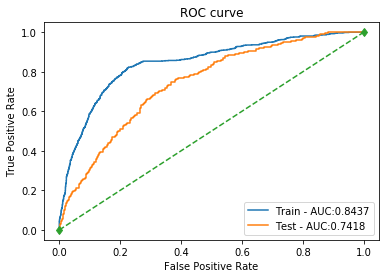

In [71]:
# 多项式SVM
model_metrics(svm_poly, X_train, X_test, y_train, y_test)

[准确率] 训练集： 0.7493 测试集： 0.7484
[精准率] 训练集： 0.0000 测试集： 0.0000
[召回率] 训练集： 0.0000 测试集： 0.0000
[f1-score] 训练集： 0.0000 测试集： 0.0000
[auc值] 训练集： 0.8300 测试集： 0.7761


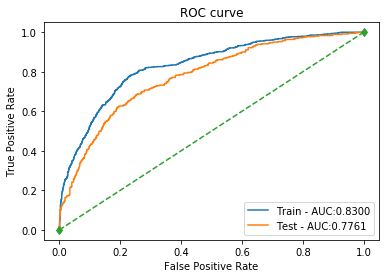

In [72]:
# 高斯核SVM
model_metrics(svm_rbf, X_train, X_test, y_train, y_test)

[准确率] 训练集： 0.7812 测试集： 0.7631
[精准率] 训练集： 0.6123 测试集： 0.5522
[召回率] 训练集： 0.3465 测试集： 0.3092
[f1-score] 训练集： 0.4426 测试集： 0.3964
[auc值] 训练集： 0.7807 测试集： 0.7091


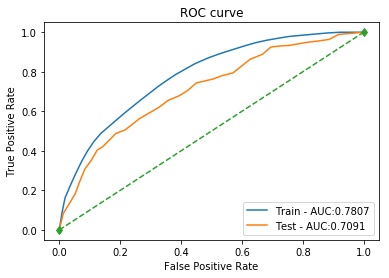

In [73]:
# 决策树
model_metrics(dt, X_train, X_test, y_train, y_test)

[准确率] 训练集： 0.8004 测试集： 0.7821
[精准率] 训练集： 0.7911 测试集： 0.6905
[召回率] 训练集： 0.2770 测试集： 0.2423
[f1-score] 训练集： 0.4103 测试集： 0.3588
[auc值] 训练集： 0.8071 测试集： 0.7518


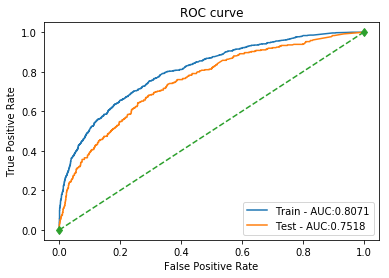

In [74]:
# XGBoost
model_metrics(xgb, X_train, X_test, y_train, y_test)

#  TASK6  

In [77]:
# from mlxtend.classifier import StackingClassifier
from mlxtend.classifier import StackingClassifier

In [78]:
svm_linear = svm.SVC(C = 0.01, kernel = 'linear', probability=True)
svm_poly =  svm.SVC(C = 0.01, kernel = 'poly', probability=True)
svm_rbf =  svm.SVC(gamma = 0.01, C =0.01 , probability=True)
dt = DecisionTreeClassifier(max_depth=9,min_samples_split=50,min_samples_leaf=90,max_features=15, random_state =2018)
xgb = XGBClassifier(learning_rate =0.01, n_estimators=40, max_depth=3, min_child_weight=9, 
                    gamma=0.4, subsample=0.8, colsample_bytree=0.85, reg_alpha=1, 
                    objective= 'binary:logistic', nthread=4,scale_pos_weight=1, seed=27)

In [80]:
sclf = StackingClassifier(classifiers = [svm_linear,svm_poly,svm_rbf,dt,xgb],meta_classifier=lr)

[准确率] 训练集： 0.8004 测试集： 0.7842
[精准率] 训练集： 0.8058 测试集： 0.7217
[召回率] 训练集： 0.2686 测试集： 0.2312
[f1-score] 训练集： 0.4029 测试集： 0.3502
[auc值] 训练集： 0.6906 测试集： 0.6509


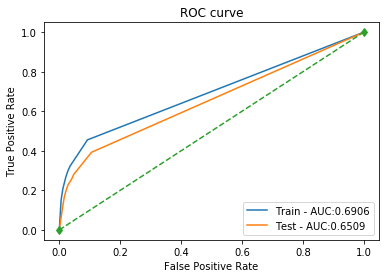

In [81]:
sclf.fit(X_train, y_train.values)
model_metrics(sclf, X_train, X_test, y_train, y_test)

In [82]:
sclf = StackingClassifier(classifiers=[svm_linear, svm_poly, svm_rbf, dt, xgb], 
                            meta_classifier=lr, use_probas=True,average_probas=False)

[准确率] 训练集： 0.8079 测试集： 0.7786
[精准率] 训练集： 0.7191 测试集： 0.6162
[召回率] 训练集： 0.3837 测试集： 0.3175
[f1-score] 训练集： 0.5004 测试集： 0.4191
[auc值] 训练集： 0.8335 测试集： 0.7679


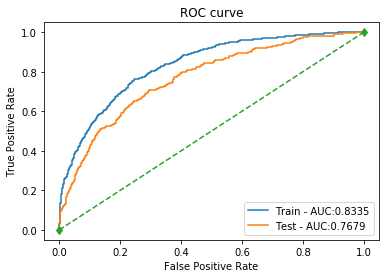

In [83]:
sclf.fit(X_train, y_train.values)
model_metrics(sclf, X_train, X_test, y_train, y_test)